In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd

import lalsimulation.gwsignal.core.waveform as wfm
import astropy.units as u
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.fisher_matrix import (
    get_waveform_derivative_1D, get_waveform_derivative_1D_with_convergence,
    fisher_val_v3
)

In [8]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [9]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

wf_center_parameters = {
    'total_mass': 100.*u.solMass,
    # 'total_mass': 10.*u.solMass,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    # 'mass_ratio': 0.42*u.dimensionless_unscaled,
    # 'sym_mass_ratio': 0.05*u.dimensionless_unscaled,
    # 'sym_mass_ratio': 0.15*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0,
    # 'condition' : 1  # Needs to be on for SEOB
    # 'spin1z': 0.42*u.dimensionless_unscaled
}

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


## Derivative Testing

In [10]:
param_to_vary = 'total_mass'
# param_to_vary = 'sym_mass_ratio'
# param_to_vary = 'mass_ratio'
# param_to_vary = 'distance'
# param_to_vary = 'spin1z'

* total_mass: very good agreement, 1e-6 relative difference for lower frequencies and not more than 1e-3 overall
* sym_mass_ratio: not perfect for 0.05, but this is very challenging territory
* mass_ratio: pretty good, relative differences are never larger than 1e-4 until $\approx 60 Hz$; larger for higher frequencies, but numdifftools error increases there drastically as well, which means this might not come from our implementation
* distance: really good for mass ratio 0.42 (1e-9 relative error), but for 0.5 it is not good, phases seem to differ quite a bit

In [11]:
num_deriv, info_dict = get_waveform_derivative_1D_with_convergence(
    wf_center_parameters,
    param_to_vary,
    gen,
    convergence_check='diff_norm',
    # convergence_threshold=0.005,
    # convergence_threshold=0.0001,  # Testing if relative difference becomes smaller when doing this -> yes it does; but computation time also increases significantly
    return_info=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

{'norm': 4.652980037409874e-40, 'final_step_size': 1e-05, 'final_convergence_val': 9.525319986653654e-06, 'number_of_refinements': 0, 'final_set_of_rel_step_sizes': array([5.e-02, 1.e-02, 5.e-03, 1.e-03, 5.e-04, 1.e-04, 5.e-05,
       1.e-05]), 'convergence_plot': <Axes: title={'center': 'Parameter: total_mass'}, xlabel='$f$', ylabel='Derivative'>}


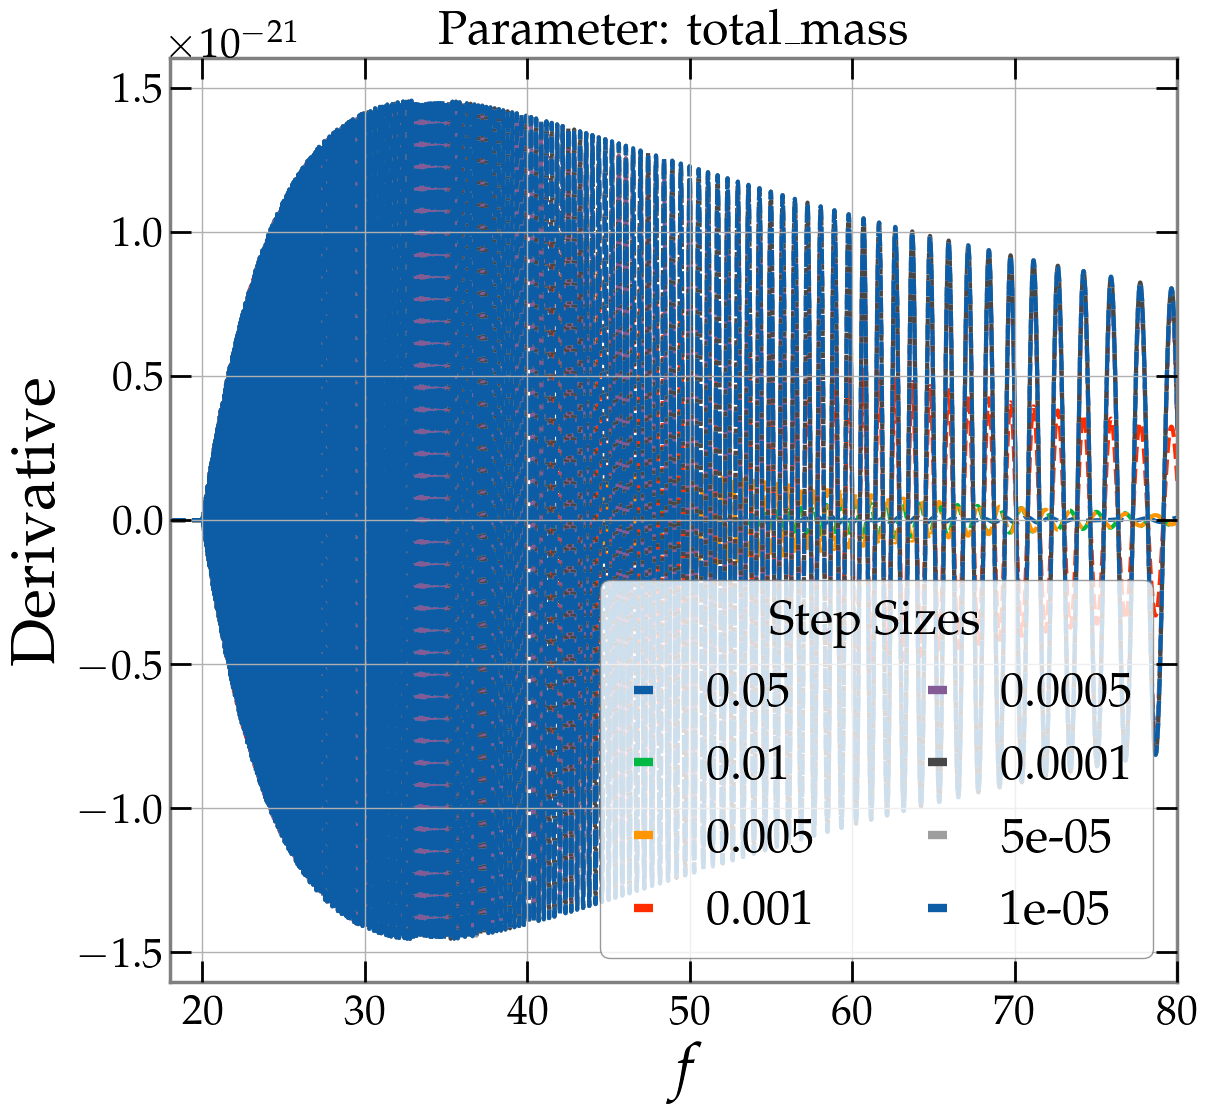

In [12]:
print(info_dict)

ax = info_dict['convergence_plot']

ax.set_xlim([18, 80])

plt.show()

In [13]:
def deriv_wrapper_real(param_val):
    # return np.real(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0])
    return wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0].real

def deriv_wrapper_imag(param_val):
    # return np.imag(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0])
    return wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0].imag


center_val = wf_center_parameters[param_to_vary]


# max_step_size = None
max_step_size = 1e-2 * center_val.value  # Seems to cause issue sometimes, maybe use value of this?

nd_deriv_real = nd.Derivative(deriv_wrapper_real, full_output=True, base_step=max_step_size)

nd_deriv_imag = nd.Derivative(deriv_wrapper_imag, full_output=True, base_step=max_step_size)
# For more step size handling, see https://numdifftools.readthedocs.io/en/latest/reference/numdifftools.html#numdifftools.step_generators.BasicMaxStepGenerator

nd_deriv = FrequencySeries(
    nd_deriv_real(center_val)[0] + 1.j * nd_deriv_imag(center_val)[0],
    frequencies=num_deriv.frequencies,
    unit=1/center_val.unit  # TODO: change to strain/ if output of lal corrected
)

nd_deriv_error_est = FrequencySeries(
    nd_deriv_real(center_val)[1].error_estimate + 1.j * nd_deriv_imag(center_val)[1].error_estimate,
    frequencies=num_deriv.frequencies,
    unit=1/center_val.unit  # TODO: change to strain/ if output of lal corrected
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

Problem: fairly frequently, bounds of allowed parameter ranges are reached

In [14]:
print(num_deriv)
print(nd_deriv)

FrequencySeries([0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j, ...,
                 3.91134668e-23+1.81809775e-23j,
                 3.91132549e-23+1.81810134e-23j,
                 1.62575323e-24+7.83382709e-25j]
                unit: 1 / solMass,
                f0: 0.0 Hz,
                df: 0.00390625 Hz,
                epoch: 0.0,
                name: hplus,
                channel: None)
FrequencySeries([0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j,
                 0.00000000e+00+0.00000000e+00j, ...,
                 3.91186671e-23+1.81832377e-23j,
                 3.91151322e-23+1.81819142e-23j,
                 1.62771821e-24+7.84499627e-25j]
                unit: 1 / solMass,
                f0: 0.0 Hz,
                df: 0.00390625 Hz,
                epoch: None,
                name: None,
                channel: None)


In [15]:
test_cutoff = 200.*u.Hz

In [16]:
# plt.plot(num_deriv.real, label='gw-signal-tools')
# plt.plot(nd_deriv.real, '--', label='numdifftools')


# # plt.plot(num_deriv.imag, label='gw-signal-tools')
# # plt.plot(nd_deriv.imag, '--', label='numdifftools')


# # plt.plot(num_deriv.abs(), label='gw-signal-tools')
# # plt.plot(nd_deriv.abs(), '--', label='numdifftools')


# plt.legend()
# plt.xlim([18, 60])
# # plt.xlim([18, test_cutoff.value])

# plt.show()

In [17]:
# # plt.plot((num_deriv - nd_deriv).abs())
# # plt.plot(((num_deriv - nd_deriv) / num_deriv).abs())
# # plt.plot(np.nan_to_num(((num_deriv - nd_deriv) / ((num_deriv + nd_deriv) / 2)).abs()))

# # plt.plot(((num_deriv - nd_deriv) / num_deriv).abs()[num_deriv != 0.0 and nd_deriv != 0.0])
# # plt.plot(((num_deriv - nd_deriv) / num_deriv).abs()[num_deriv != 0.0])

# # plt.plot(((num_deriv - nd_deriv) / num_deriv).abs().crop(end=605.))  # Seems to be only way to avoid large relative errors where derivatives become zero
# plt.plot(((num_deriv - nd_deriv) / num_deriv).abs().crop(end=test_cutoff))  # Seems to be only way to avoid large relative errors where derivatives become zero


# plt.xlim([18, 60])
# plt.xlim([18, test_cutoff.value])
# # plt.xlim([600, 620])

# plt.yscale('log')

# plt.show()

In [18]:
# plt.plot(nd_deriv_error_est)  # Seems to be only way to avoid large relative errors where derivatives become zero


# plt.xlim([18, 60])
# plt.xlim([18, test_cutoff.value])
# # plt.xlim([600, 620])

# plt.yscale('log')

# plt.show()

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


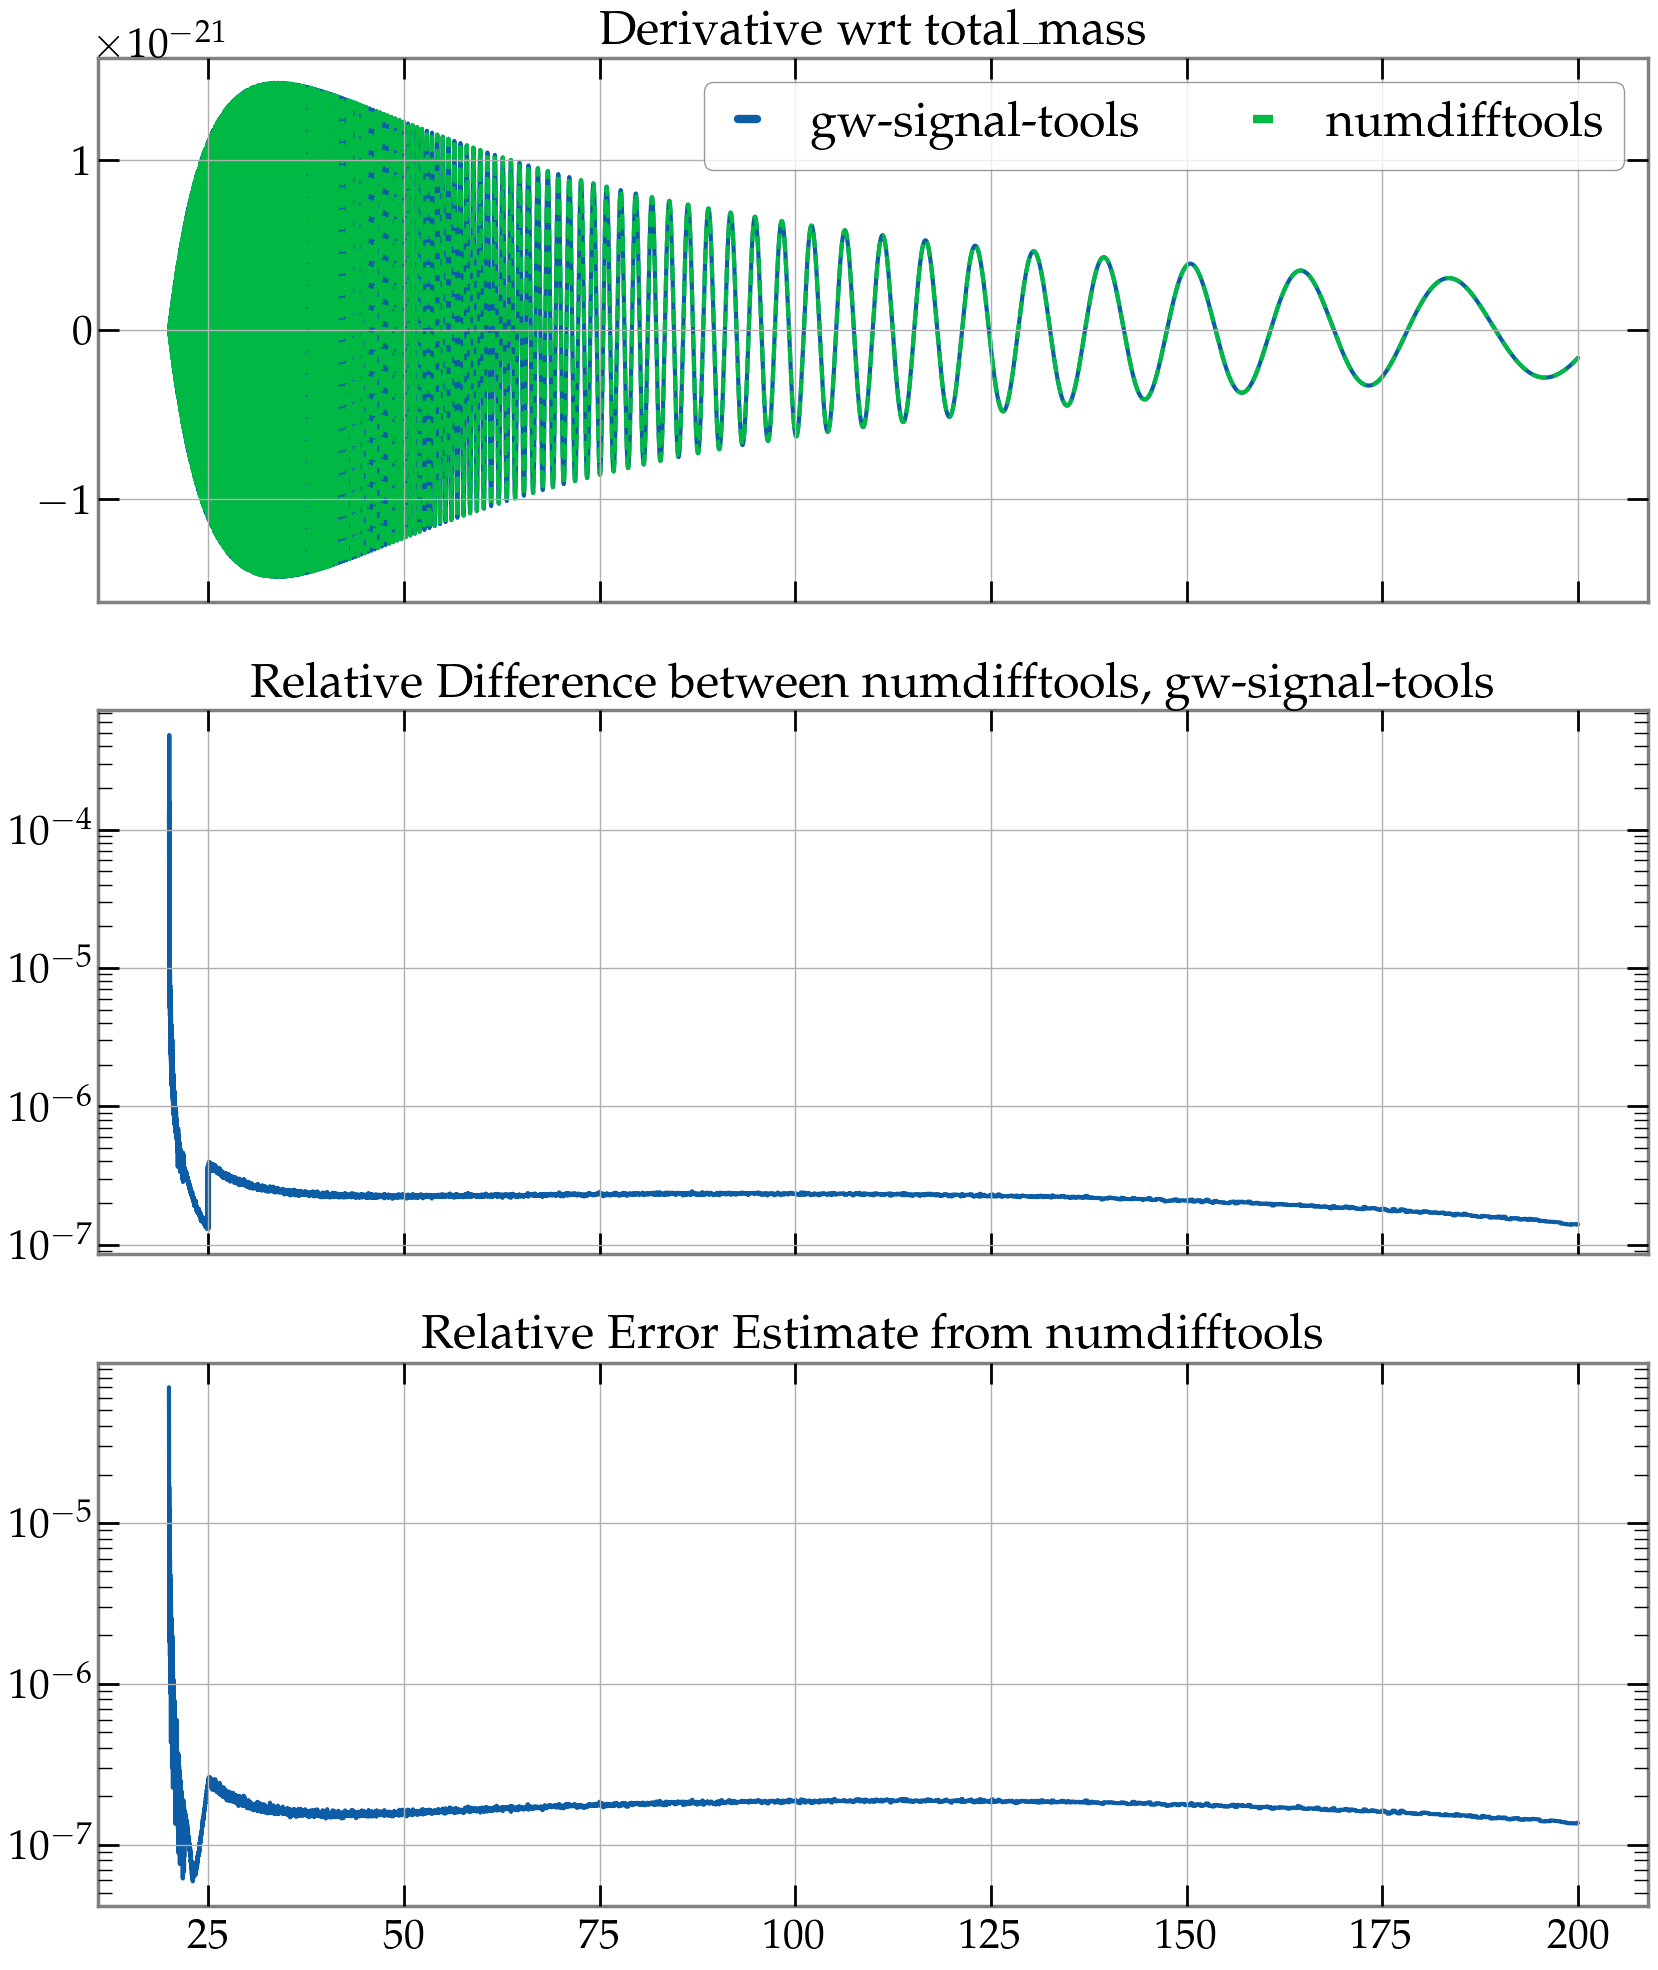

In [19]:
# f_range=[f_min, f_max]
# f_range=[f_min, 60. * u.Hz]
f_range=[f_min, 200. * u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0,].plot(num_deriv.crop(start=f_range[0], end=f_range[1]), label='gw-signal-tools')
ax[0,].plot(nd_deriv.crop(start=f_range[0], end=f_range[1]), '--', label='numdifftools')

ax[0,].set_title(f'Derivative wrt {param_to_vary}')
ax[0,].legend(ncols=2)


ax[1,].plot(((num_deriv - nd_deriv) / num_deriv).abs().crop(start=f_range[0], end=f_range[1]))
# ax[1,].plot(nd_deriv.frequencies[nd_deriv.frequencies < f_cutoff], np.nan_to_num(((num_deriv - nd_deriv) / num_deriv).abs()).crop(end=f_cutoff))  # Same result, 0 not visible in log-plot

ax[1,].set_yscale('log')
ax[1,].set_title('Relative Difference between numdifftools, gw-signal-tools')


# ax[2,].plot(nd_deriv_error_est.crop(start=f_range[0], end=f_range[1]))
ax[2,].plot((nd_deriv_error_est / nd_deriv).abs().crop(start=f_range[0], end=f_range[1]))

ax[2,].set_yscale('log')
# ax[2,].set_title('Absolute Error Estimate from numdifftools')
ax[2,].set_title('Relative Error Estimate from numdifftools')

plt.show()

Relative difference on scale of error estimate is good, right? Should mean we get equal to numdifftools result that we are on scale of its error, i.e. the deviation need not come from our own implementation

In [20]:
from gw_signal_tools.inner_product import norm

In [21]:
# fisher1 = norm(num_deriv)
# fisher2 = norm(nd_deriv)

fisher1 = norm(num_deriv, f_range=f_range)
fisher2 = norm(nd_deriv, f_range=f_range)

In [22]:
print(fisher1, fisher2, abs((fisher1 - fisher2) / fisher1))

2.073262202036784e-20 2.0732626897134898e-20 2.352219152213974e-07


Agreement is good, only real deviations (around 1%) occur for extreme situations like very small symmetric mass ratio